Model From https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

In [2]:
#batch, dim, npoints
sim_data = Variable(torch.rand(32,3,500))
print(sim_data.shape)


torch.Size([32, 3, 500])


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


# prepare some coordinates
x, y, z = np.indices((8, 8, 3))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x < 1) & (y < 1) & (z < 1)
cube2 = (x >= 2) & (y >= 2) & (z >= 2)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2

# combine the objects into a single boolean array
voxels = cube1 | cube2 | link

# set the colors of each object
colors = np.empty(voxels.shape, dtype=object)
colors[link] = 'red'
colors[cube1] = 'blue'
colors[cube2] = 'green'
print(colors.shape)

# and plot everything
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, facecolors=colors, edgecolor='k')

plt.show()

(8, 8, 3)


<Figure size 640x480 with 1 Axes>

https://github.com/meder411/PointNet-PyTorch/blob/master/models/transformer.py

In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as grad



##-----------------------------------------------------------------------------
# Class for Transformer. Subclasses PyTorch's own "nn" module
#
# Computes a KxK affine transform from the input data to transform inputs
# to a "canonical view"
##
class Transformer(nn.Module):
    def __init__(self, num_points=2000, K=3):
        # Call the super constructor
        print (num_points, K)
        super(Transformer, self).__init__()

        # Number of dimensions of the data
        self.K = K

        # Size of input
        self.N = num_points
        if num_points < 201:
            print ("this will fail too small resize to minimum of 201")
            self.N = 201

        # Initialize identity matrix on the GPU (do this here so it only 
        # happens once)
        self.identity = grad.Variable(
            torch.eye(self.K).double().view(-1).cuda())

        # First embedding block
        self.block1 =nn.Sequential(
            nn.Conv1d(K, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        # Second embedding block
        self.block2 =nn.Sequential(
            nn.Conv1d(64, 128, 1),
            nn.BatchNorm1d(128),
            nn.ReLU())

        # Third embedding block
        self.block3 =nn.Sequential(
            nn.Conv1d(128, 64, 1),
            nn.BatchNorm1d(64),
            nn.ReLU())

        # Multilayer perceptron
        self.mlp = nn.Sequential(
            nn.Linear(64, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, K * K))


    # Take as input a B x K x N matrix of B batches of N points with K 
    # dimensions
    def forward(self, x):

        # Compute the feature extractions
        # Output should ultimately be B x 1024 x N
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        # Pool over the number of points
        # Output should be B x 1024 x 1 --> B x 1024 (after squeeze)
        x = F.max_pool1d(x, self.N).squeeze(2)
        # Run the pooled features through the multi-layer perceptron
        # Output should be B x K^2
        x = self.mlp(x)

        # Add identity matrix to transform
        # Output is still B x K^2 (broadcasting takes care of batch dimension)
        x += self.identity

        # Reshape the output into B x K x K affine transformation matrices
        x = x.view(-1, self.K, self.K)

        return x


In [51]:
sim_data = Variable(torch.rand(32,3,400)).cuda()
sim_data2 = Variable(torch.rand(32,3,350)).cuda()
t = Transformer(num_points=201, K=3).cuda()
t(sim_data2).shape

201 3


torch.Size([32, 3, 3])

In [6]:
#t(sim_data2).shape

In [7]:
#sim_data = Variable(torch.rand(32,3,4000)).cuda()
#t = Transformer(num_points=2500, K=3).cuda()
#t(sim_data).shape

### Source https://discuss.pytorch.org/t/which-part-of-pytorch-tensor-represents-channels/21778
The first number represents the Batchsize (N) and for tensors holding data of a dimension of 1 or above the next dimension is usually referred to as channel-dimension. The following dimensions are commonly height, width and depth.
So for 2d data (images) you have a 4d tensor of NxCxHxW which you feed into a 2d conv layer.

Note that channels only exist for convolutional layers. Linear layers for example need a shape of N x #num_features

In [52]:
#TODO
import random
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path="", pointsnumber=1000):
        #how many pointclouds
        self.nsamples = pointsnumber
        self.random = random
        self.pointsnumber = pointsnumber

    def __getitem__(self,index):
        x = np.zeros((3, self.nsamples), dtype=np.double)
        y = 1
        return (x,1)
    
    def __len__(self):
        return self.nsamples

In [53]:
class WrappedDataLoader:
    def __init__(self, dl,nsamples):
        self.dl = dl
        self.func = self.tocuda
        self.batchsize = len(self.dl)
        self.nsamples = nsamples
    
    def tocuda(self,x,y):
        return x.cuda(), y.cuda()

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [54]:
#OR train_ds = TensorDataset(x_train, y_train)

def get_data(train_ds, valid_ds, bs, nsamples):
    return (
        WrappedDataLoader(DataLoader(train_ds, batch_size=bs), nsamples),
        WrappedDataLoader(DataLoader(valid_ds, batch_size=bs), nsamples),
    )

#gen = DataLoader(TensorDataset(data, labels), batch_size=25, shuffle=True)


In [55]:
pointsnumber = 1500
batchsize = 10

In [56]:
from torch.utils.data import DataLoader, TensorDataset
itdataset = MyDataset(pointsnumber=pointsnumber)
traingen, valgen = get_data(itdataset,itdataset,bs=batchsize, nsamples=itdataset.nsamples)

In [57]:
class MyModel(torch.nn.Module):
    def __init__(self, n_points=500):
        super(MyModel, self).__init__()
        self.n_points = n_points
        self.transformer = Transformer(150)
        self.conv1 = torch.nn.Conv1d(3, 32, 1)
        self.conv2 = torch.nn.Conv1d(32, 16, 1)
        self.conv3 = torch.nn.Conv1d(16, 1, 1)
        self.lin1 = torch.nn.Linear(30, 1)
        self.bn1 = nn.BatchNorm1d(32)
        self.bn2 = nn.BatchNorm1d(16)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.2)
        self.batch_loss = list()

    def forward(self, x):
        batchsize = x.size()[0]
        #remove
        x = x[:,:,:random.randint(202,250)]
        
        x = self.transformer(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #x = torch.max(x, 2, keepdim=True)
        #x = x.view(batchsize,-1)
        x = x.flatten()
        x = F.relu(self.lin1(x))
        #print(x.item(), "TEST")
        return x

    def trainbatch(self,x,targets,batchid):
        self.optimizer.zero_grad()
        output = self.__call__(x)
        
        loss = self.criterion(output,targets)
        loss.backward()
        self.optimizer.step()

        self.epoch_loss += loss.item()
        self.batch_loss.append(loss.item())

        #print("Batch {} - batch loss: {}".format(batchid, loss.item()))

    def mytrain(self,traindata,valdata,nepochs=5,valsamples=10, device="cuda"):
        epoch_loss = list()
        #self.batch_loss = list()
        self.train()

        for epoch in range(nepochs):

            self.epoch_loss = 0.0

            #batches number
            for b,x in enumerate(traindata):
                self.trainbatch(x[0].float(),x[1].float(),b)

            self.epoch_loss /= traindata.nsamples
            
            print("Epoch {} - epoch loss: {}".format(epoch, self.epoch_loss), end=" ")
            epoch_loss.append(self.epoch_loss)

            #validation
            self.eval()
            with torch.no_grad():
                valid_loss = sum(self.criterion(self.__call__(xb.float()), yb.float()) for xb, yb in valdata)
            print(" validation loss {}".format(valid_loss/valdata.nsamples), sep="..")
        return epoch_loss

    def predict(self,x):
        with torch.no_grad():
            return self.__call__(x)

# Note from pytorch tutorial for validation

def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

...

model.eval()

with torch.no_grad():

    losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
    )
    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums

In [58]:
mymodel = MyModel(n_points=pointsnumber)

150 3
this will fail too small resize to minimum of 201


In [59]:
device = torch.device("cpu")
if torch.cuda.is_available():
    #sim_data = Variable(torch.rand(2,3,1))
    device = torch.device("cuda")          # a CUDA device object
    #y = torch.ones_like(sim_data, device=device)  # directly create a tensor on GPU
    #x = sim_data.to(device)                       # or just use strings ``.to("cuda")``
    #print(x)
    #print(x.to("cpu", torch.double))       # ``.to`` can also change dtype together!
    mymodel.cuda()
#print(device)
losses = mymodel.mytrain(traingen, valgen,nepochs=25)

Epoch 0 - epoch loss: 0.0009111337745876397  validation loss 872937226240.0
Epoch 1 - epoch loss: 5819572333.326  validation loss 0.10000000149011612
Epoch 2 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 3 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 4 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 5 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 6 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 7 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 8 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 9 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 10 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 11 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 12 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 13 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 14 - epoch loss: 0.1  validation loss 0.10000000149011612
Epoch 15 - epoch loss: 0.1

In [ ]:
#print(torch.randint(0,10,(10,1)))

In [61]:
import numpy as np
"""
params = list(mymodel.parameters())
print(len(params))
print(params[0].size())
acc = np.sum([i.sum().cpu().detach().numpy() for i in params])
print([i.sum().cpu().detach().numpy() for i in params])
print(acc)
"""

'\nparams = list(mymodel.parameters())\nprint(len(params))\nprint(params[0].size())\nacc = np.sum([i.sum().cpu().detach().numpy() for i in params])\nprint([i.sum().cpu().detach().numpy() for i in params])\nprint(acc)\n'

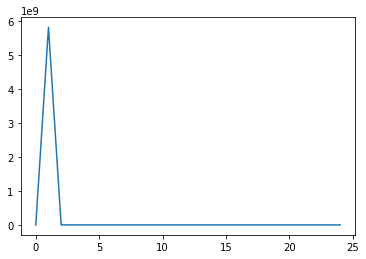

In [62]:
plt.plot(np.arange(len(losses)), losses)

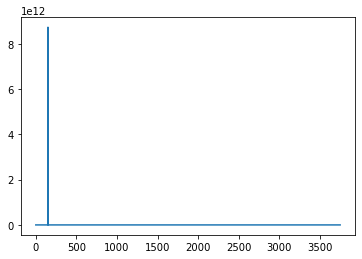

In [63]:
plt.plot(np.arange(len(mymodel.batch_loss)), mymodel.batch_loss)

In [64]:
mymodel.criterion

MSELoss()

In [70]:
print(device)
x = Variable(torch.rand(batchsize,3,mymodel.n_points)).to(device)
targets = torch.rand((batchsize,1)).to(device)
y_pred = mymodel.predict(x)
print("MSE {}".format(((targets - y_pred)**2).sum()))

cuda
MSE 2.7555952072143555


# TESTING TENSORBOARD

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('scalar/testingtensorboard')

In [ ]:
for step in range(-360, 360):
    angle_rad = step * math.pi / 180
    writer.add_scalar('sin', math.sin(angle_rad)*step, step)
    writer.add_scalar('cos', math.cos(angle_rad)*step, step)
    writer.add_scalars('sin and cos', {'sin': math.sin(angle_rad), 'cos': math.cos(angle_rad)}, step)

In [ ]:
dataiter = iter(traingen)
databatch, labels = next(dataiter)
writer.add_graph(mymodel, databatch.float())


In [ ]:
for n_iter in range(100):
    writer.add_scalar('Loss/train', np.random.random(), n_iter)
    writer.add_scalar('Loss/test', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/train', np.random.random(), n_iter)
    writer.add_scalar('Accuracy/test', np.random.random(), n_iter)

In [ ]:
r = 5
for i in range(100):
    writer.add_scalars('run_14h', {'xsinx':i*np.sin(i/r),
                                    'xcosx':i*np.cos(i/r),
                                    'tanx': np.tan(i/r)}, i)

In [ ]:
sigma = 1
for step in range(5):
    writer.add_histogram('hist-numpy', np.random.normal(0, sigma, 1000), step)
    sigma += 1
sigma = 1
for step in range(5):
    torch_normal = torch.distributions.Normal(0, sigma)
    writer.add_histogram('hist-torch', torch_normal.sample((1, 1000)), step)
    sigma += 1

In [ ]:
data = torch.rand((10,3,20,20))
labels = torch.ones(10,1,400)
#perm = torch.randperm(5)
#data = data[perm]
#data = data.view(100,-1)
#data = data.squeeze(0)
out = torch.rand((10,20*20*3,2))#.flatten()
#features.shape, data.shape, labels.ndim

In [ ]:
#TODO
"""
print(out.shape, out.size(0), out.ndim, data.size(0))
print(data.shape, data.ndim, data.shape[1], data.size(0))
print(labels.shape, labels.ndim)
writer.add_embedding
#(data.squeeze(0),
#                    metadata=labels.squeeze(0),
#                    label_img=data,#.squeeze(0),
#                    global_step=1)
writer.close()
"""

#HELP
"""
   print("loss_value:{}".format(loss_value.data.item()))
            # we need 3 dimension for tensor to visualize it!
            out = torch.cat((out.data, torch.ones(len(out), 1)), 1)
            writer.add_embedding(
                out,
                metadata=label_batch.data,
                label_img=data_batch.data,
                global_step=n_iter)
"""

In [ ]:
writer.close()

For Classification

In [ ]:
"""
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
"""


def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)